In [2]:
import cv2, copy
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [3]:
from sketch2code.datasets import *
from sketch2code.data_model import Pix2CodeTag
from sketch2code.config import *
from s1x_supervise_baseline import make_pix2code_vocab_v1

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Purpose

This notebook is to prepare dataset for pix2code so that we can run to evaluate pix2code

header { btn-active, btn-inactive } row { quadruple { small-title, text, btn-green } quadruple { small-title, text, btn-red } quadruple { small-title, text, btn-green } quadruple { small-title, text, btn-green } } row { single { small-title, text, btn-red } } row { double { small-title, text, btn-orange } double { small-title, text, btn-orange } } 
average program size 52.94571428571429


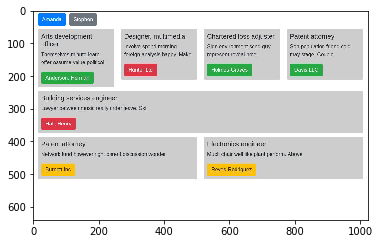

In [4]:
tags, oimages = load_dataset('pix2code')
with open(ROOT_DIR / "datasets" / "pix2code" / "data.trace.json", "r") as f:
    trace = ujson.load(f)

print(trace[524]['dsl'])
plt.imshow(oimages[524])
print("average program size", np.mean([len(p['dsl'].split(" ")) for p in trace]))

#### Execute Pix2Code

**Step 1**: Prepare data

In [31]:
EVAL_DIR = ROOT_DIR / "../pix2code_eval"

!rm -r {EVAL_DIR}
!mkdir -p {EVAL_DIR}/training
!mkdir -p {EVAL_DIR}/testing

/home/rook/workspace/CSCI559/Project/sketch2code/tmp


In [32]:
for i, (dsl_program, img) in tqdm(enumerate(zip(trace[:1500], oimages[:1500])), total=len(oimages[:1500])):
    with open(EVAL_DIR / "training" / f"page_{i:05}.gui", "w") as f:
        f.write(dsl_program['dsl'])
    imageio.imwrite(EVAL_DIR / "training" / f"page_{i:05}.png", img)
    
for i, (dsl_program, img) in tqdm(enumerate(zip(trace[1500:], oimages[1500:]), start=1500), total=len(oimages[1500:])):
    with open(EVAL_DIR / "testing" / f"page_{i:05}.gui", "w") as f:
        f.write(dsl_program['dsl'])
    imageio.imwrite(EVAL_DIR / "testing" / f"page_{i:05}.png", img)

100%|██████████| 250/250 [00:26<00:00,  9.62it/s]


In [33]:
%cd {ROOT_DIR}/../pix2code/model

!./convert_imgs_to_arrays.py {EVAL_DIR}/training {EVAL_DIR}/training_features
!./convert_imgs_to_arrays.py {EVAL_DIR}/testing {EVAL_DIR}/testing_features

/home/rook/workspace/CSCI559/Project/pix2code/model
Converting images to numpy arrays...
Numpy arrays saved in /home/rook/workspace/CSCI559/Project/sketch2code/tmp/pix2code_eval/training_features
Converting images to numpy arrays...
Numpy arrays saved in /home/rook/workspace/CSCI559/Project/sketch2code/tmp/pix2code_eval/testing_features


**Step 2:** Train the model

**Step 3**: Evaluate pix2code

We report the average accuracy of programs. The accuracy of a program is percentage of tokens that matches with the correct programs (need to be in correct position as well)

In [42]:
%cd {ROOT_DIR}/../pix2code/model
!mkdir {EVAL_DIR}/code
!./generate.py {EVAL_DIR}/bin pix2code {EVAL_DIR}/testing {EVAL_DIR}/code 3

/home/rook/workspace/CSCI559/Project/pix2code/model
Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2019-04-20 10:29:36.890343: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-04-20 10:29:36.912780: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2098850000 Hz
2019-04-20 10:29:36.913465: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55db663a7860 executing computations on platform Host. Devices:
2019-04-20 10:29:36.913483: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-04-20 10:29:37.053597: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55db664533c0 executing computations on platform CUDA. Devices:
2019

In [126]:
!mkdir -p {EVAL_DIR}/code_eval
make_pix2code(EVAL_DIR / "code", EVAL_DIR / "code_eval", skip_on_error=True)

Error while parsing page_01652.gui. Cannot parse program: header{btn-inactive,btn-inactive,btn-inactive,btn-active,btn-inactive}row{single{small-title,text,btn-green}}{small-title,text,btn-orange}}row{quadruple{small-title,text,btn-green}quadruple{small-title,text,btn-green}}{small-title,text,,btn-green}quadruple{small-title,text,btn-green}}
Error while parsing page_01700.gui. Cannot parse program: header{btn-inactive,btn-inactive,btn-inactive,btn-inactive{double{small-title,text,btn-orange}double{small-title,text,btn-orange}}row{quadruple{small-title,text,btn-orange}quadruple{small-title,text,btn-orange}quadruple{small-title,text,btn-green}quadruple{small-title,text,btn-orange}}


In [139]:
vocab, ivocab = make_pix2code_vocab_v1()

with open(EVAL_DIR / "code_eval" / "data.trace.json", "r") as f:
    test_trace = ujson.load(f)
    for p in test_trace:
        p['idx'] = int(p['file'].replace("page_", ""))
        p['tag'] = Pix2CodeTag.deserialize(p['tag'])
    
    test_trace = {p['idx']: p for p in test_trace} 

accuracies = []
for i, tag in enumerate(tags[1500:], start=1500):
    if i not in test_trace:
        accuracies.append(0.0)
        continue
    
    tag_pred = test_trace[i]
    gprog = [vocab[w] for w in tag.linearize(replace_text=True).str_tokens]
    pprog = [vocab[w] for w in tag_pred['tag'].linearize(replace_text=True).str_tokens]
    
    n_matches_token = 0
    # append to make the lengths of the programs equal, but make sure the appended token raise a mismatch
    if len(gprog) >= len(pprog):
        a, b = gprog, pprog
    else:
        a, b = pprog, gprog
    for i in range(len(a) - len(b)):
        b.append(-999)    
    for w0, w1 in zip(a, b):
        n_matches_token += int(w0 == w1)
    accuracies.append(n_matches_token / len(a))
assert len(accuracies) == 250
print('accuracy', np.mean(accuracies))

accuracy 0.7938562530419379
